# Investigating Hybrid Strategies for Systematic Literature Review
**Experiment 1**

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

SVG = False

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)

    @property
    def draw(self):
        if SVG:
            return self._ipython_display_()
        from subprocess import Popen, PIPE as P
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['dot', '-T', "png"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/png'] = image
        except OSError as e:
            if e.errno != os.errno.ENOENT:
                raise

        bundle['text/plain'] = '\n'.join(map(str, self.log))
        display(bundle, raw=True)



def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", 
        "precision", 
        "recall", 
        "fmeasure", 
        "final_precision", 
        "final_recall", 
        "final_fmeasure", 
        "operation", 
        "delta_related", 
        "delta_visited", 
        "delta_selected",
        "related", 
        "visited", 
        "final_selected",
        "accumulated_precision", 
        "accumulated_recall", 
        "accumulated_fmeasure",
        "final_accumulated_precision", 
        "final_accumulated_recall", 
        "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [3]:
print ("\nTotal de estudos primários reproduzidos = 22 do Seed Set + 29 encontrados durante o Snowballing =", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))


Total de estudos primários reproduzidos = 22 do Seed Set + 29 encontrados durante o Snowballing = 51


In [4]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

arraysearch = []
for listdl in ("scopus_search","springer_search", "ieee_search", "sciencedirect_search","acm_search","webofscience_search", "elcompendex_search"):
    search_title = {x for _, x in load_work_map_all_years() if getattr(x, listdl, 0)}
    recall_title = (len(search_title) / len(TOTAL))
    dl_row = [listdl[:-7]] + [recall_title]
    arraysearch.append(dl_row)
    
#print (arraysearch)

strategy = Strategy(*busca("ieee2015", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);


 Provenance Graph - Strategy 1 - Database Search


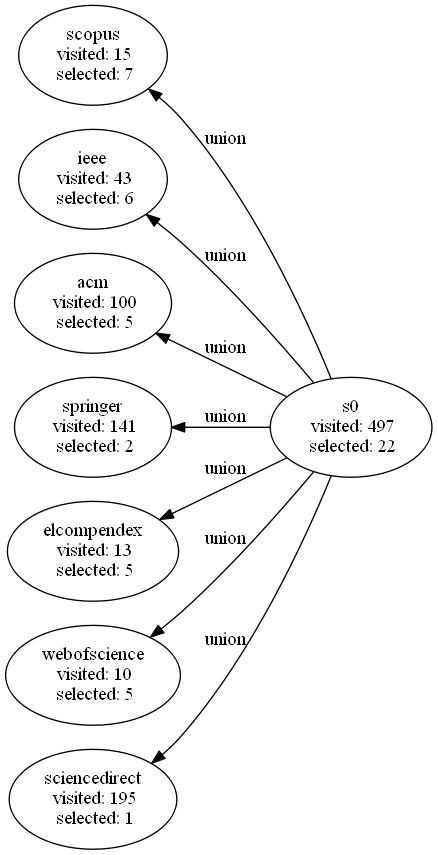

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl [:-4]
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
state = strategy.initial

final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 1 - Database Search\033[0m")

final.draw

In [6]:
# salva o gráfico de proveniência no formato para incluir em pdf, word.
def salvar(state, arquivo):
    with open("{}.dot".format(arquivo), "w") as f:
        f.write(state.dot)
    !dot -Tsvg {arquivo}.dot -o {arquivo}.svg
    !inkscape -f {arquivo}.svg -e {arquivo}.png -d 300

In [7]:
#salvar(final, "E1final")

In [8]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)


                                  
#df1 = df[["state", "precision", "recall", "fmeasure", 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']]
df1 = df[["state", "precision", "recall", "fmeasure"]]
df1.columns = ['Digital Library', 'Precision %', 'Recall %', 'F-Measure %']


df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']
df2 = df2.loc[df['state'] == 's0']

df1 = df1.drop(df.index[[-1,7]])

df2_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df2_style.hidden_index = True
dfE1 = df2_style
dfE1r =df1
print("\n \033[1mReport Strategy 1 - Database Search\033[0m")
df2_style


 Report Strategy 1 - Database Search


Digital Library,Precision %,Recall %,F-Measure %
sciencedirect,0.5,2,0.8
webofscience,50,9.8,16.4
elcompendex,38.5,9.8,15.6
springer,1.4,3.9,2.1
acm,5,9.8,6.6
ieee,14,11.8,12.8
scopus,46.7,13.7,21.2


In [9]:
df.to_excel("estrategia1.xlsx")


  Bar Chart Strategy 1 


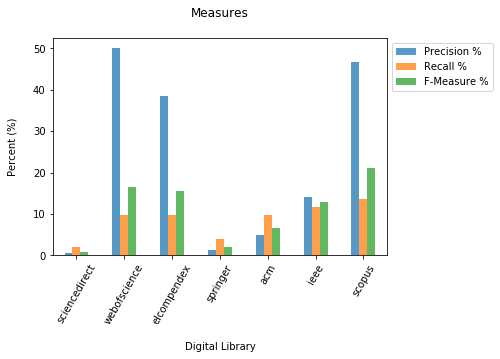

In [10]:
df1.plot.bar(y=['Precision %', 'Recall %', 'F-Measure %'], alpha=0.75, rot=60)
ax = plt.gca()
ax.set_title("Measures\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df1['Digital Library'])
plt.xlabel("\nDigital Library")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 1 \033[0m')

In [11]:
df2_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df2_style.hidden_index = True
print("\n \033[1mReport Strategy 1 Measures (Accumulated) \033[0m")
df2_style


 Report Strategy 1 Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
4.4,43.1,8,497,22



  Bar Chart Publications Type - Strategy 1 
 


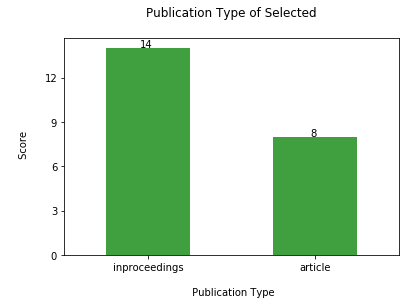

In [12]:
lista = [work.entrytype for work in state.related]
df = pd.DataFrame (lista)

ax = df.apply(pd.value_counts).plot(kind="bar", color = 'green',legend = False, alpha=0.75, rot=0)
ax.set_title("Publication Type of Selected\n")

ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.xlabel("\n Publication Type")
plt.ylabel("\n Score\n")

print ('\n \033[1m Bar Chart Publications Type - Strategy 1 \n \033[0m')

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.000, p.get_height() * 1.005 ), ha='center', va='center', xytext=(40, 3), textcoords='offset points')


  Bar Chart Publications Year - Strategy 1 
 


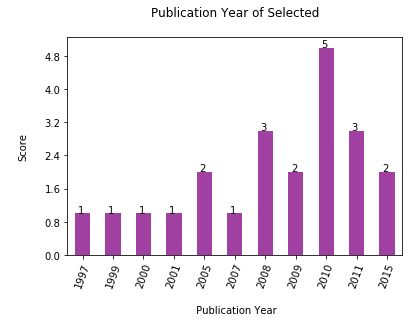

In [13]:
listayear = [work.year for work in state.related] 
df = pd.DataFrame (listayear)
df
df = df[[0]] 
df.columns = ['Selected']
df1 = df.sort_values('Selected', ascending=False)
df2 = df1.groupby(['Selected']).size().reset_index()
df2.sort_values('Selected', ascending=False)
df2

df2.plot.bar(x= "Selected", y=[0], color = 'purple', legend = False, alpha=0.75, rot=70)
ax = plt.gca()
ax.set_title("Publication Year of Selected\n")

ax.yaxis.set_major_locator(plt.MaxNLocator(7))

plt.xlabel("\n Publication Year")
plt.ylabel("\nScore\n")
print ('\n \033[1m Bar Chart Publications Year - Strategy 1 \n \033[0m')

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.000, p.get_height() * 1.005 ), ha='center', va='center', xytext=(6, 3), textcoords='offset points')
 

## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


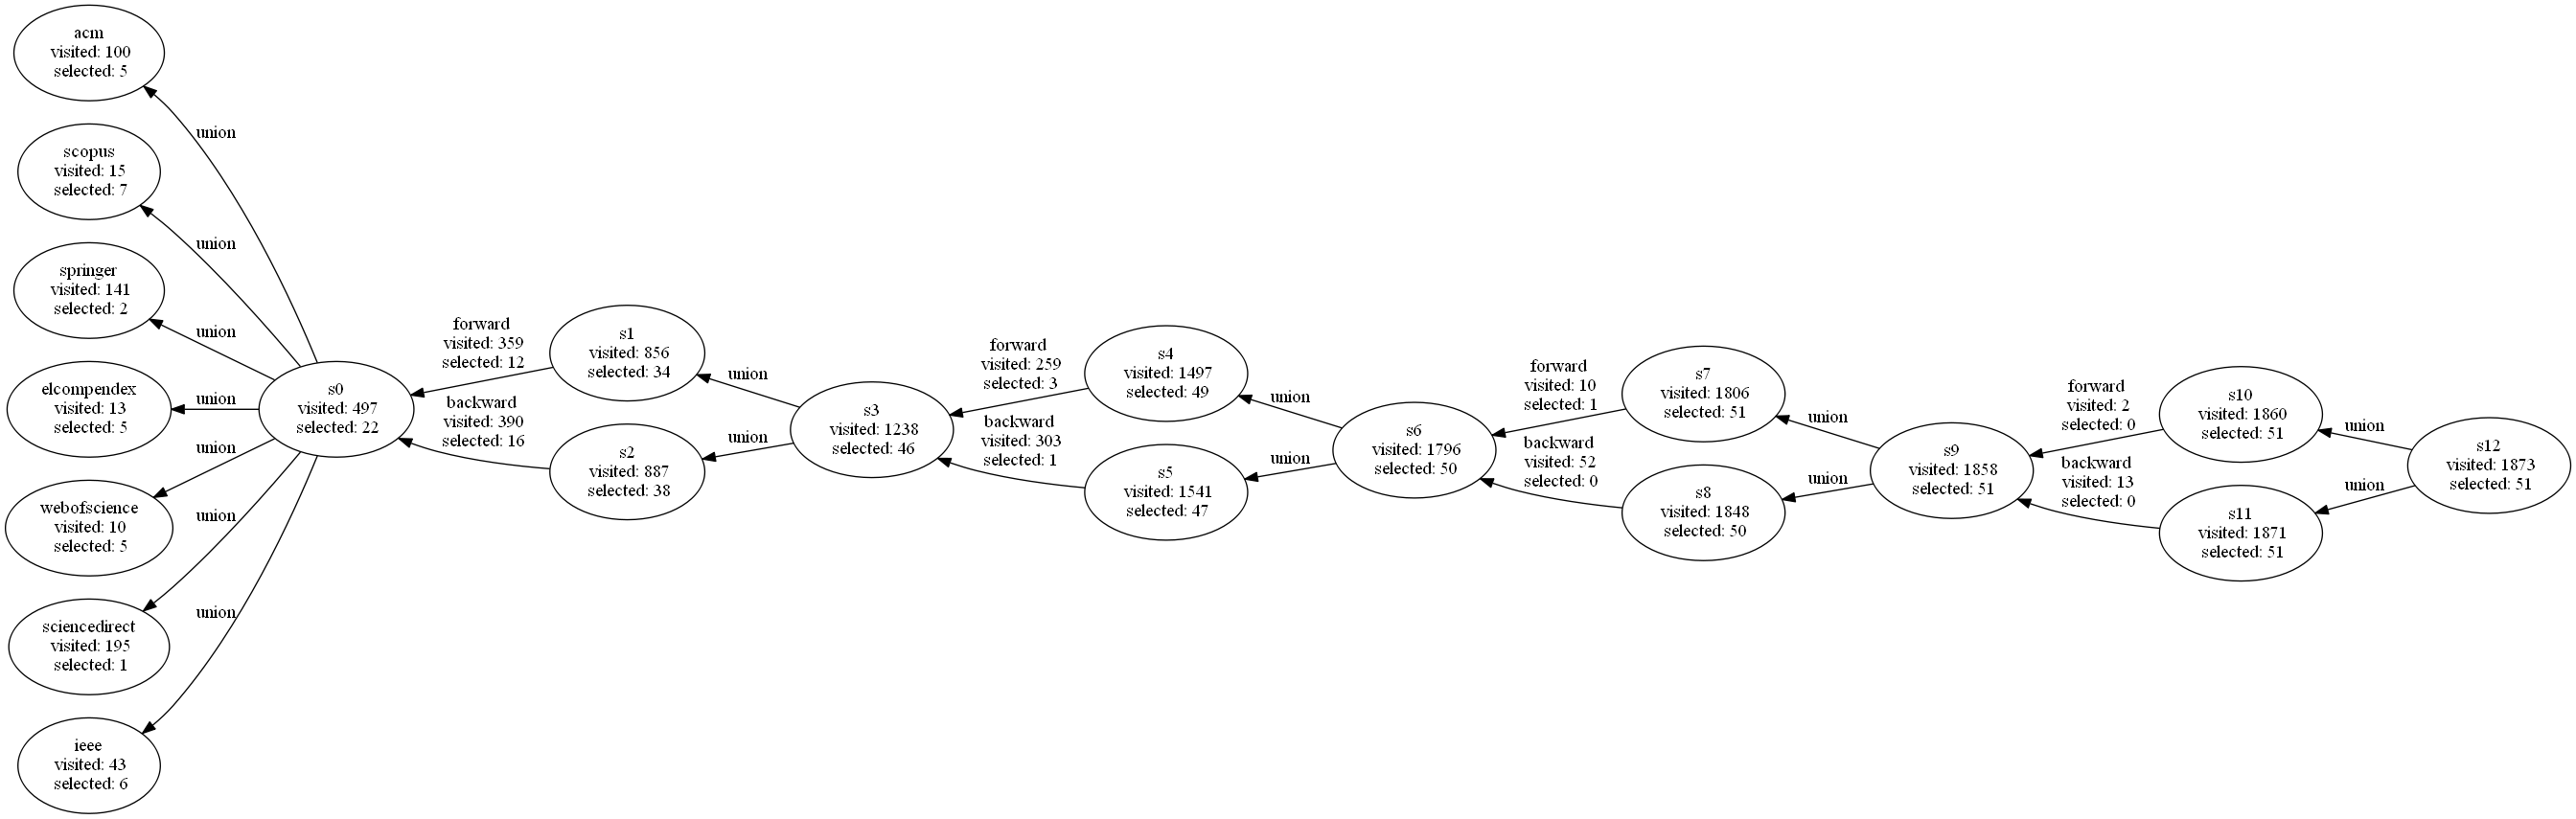

In [14]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
state = strategy.sfbu()
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 2 - Database Search + Snowballing (Guideline Wohlin)\033[0m")

final.draw

In [15]:
#salvar(final, "E2final")

In [16]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

#d_decimals = 3    
#for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
#      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
#df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
    
    
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Digital Library/State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]

    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
print("\n \033[1mReport Strategy 2 - Database Search + Snowballing (Guideline Wohlin)\033[0m")
df1_style


 Report Strategy 2 - Database Search + Snowballing (Guideline Wohlin)


Digital Library/State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
ieee,14,11.8,12.8,-,14,11.8,12.8,43,43,6,6
sciencedirect,0.5,2,0.8,-,0.5,2,0.8,195,195,1,1
webofscience,50,9.8,16.4,-,50,9.8,16.4,10,10,5,5
elcompendex,38.5,9.8,15.6,-,38.5,9.8,15.6,13,13,5,5
springer,1.4,3.9,2.1,-,1.4,3.9,2.1,141,141,2,2
scopus,46.7,13.7,21.2,-,46.7,13.7,21.2,15,15,7,7
acm,5,9.8,6.6,-,5,9.8,6.6,100,100,5,5
s0,nan,0,0,union,4.4,43.1,8,0,497,0,22
s2,4.1,31.4,7.3,backward,4.3,74.5,8.1,390,887,16,38
s1,3.3,23.5,5.9,forward,4,66.7,7.5,359,856,12,34


In [17]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 2 - Measures (Accumulated) \033[0m")
df3_style




 Report Strategy 2 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
2.7,100,5.3,1873,51


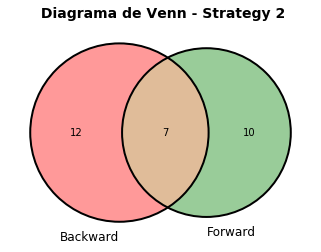

In [18]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 2',fontsize="14", fontweight="bold")
plt.show()

In [19]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['liu2005a', 'münch2013a', 'mccoy1998a', 'martins2007b', 'kowalczyk2010a', 'debou2000a', 'basili2007c', 'münch2013c', 'liu2006a', 'mcloughlin2010a', 'mandić2010d', 'basili2007a', 'trendowicz2011a', 'basili2007b', 'lepmets2014a', 'armbrust2010a', 'murugappan2003a', 'messnarz1999a', 'hinley1995a']
Forward ['trienekens2004a', 'armbrust2010b', 'münch2013a', 'kowalczyk2010a', 'stallinger2013a', 'münch2013c', 'mandić2010d', 'mcloughlin2010a', 'sun2010a', 'unterkalmsteiner2014a', 'mcloughlin2010b', 'karlström2002a', 'trendowicz2011a', 'armbrust2010a', 'birkhölzer2011a', 'cocozza2014a', 'trendowicz2014a']


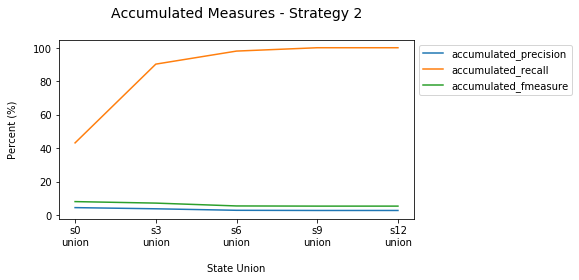

In [20]:
# ---- Grafico de linha para Somente Union 
df = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
plt.xticks(np.arange(0, len(df), 1.0), rotation='horizontal')
plt.xlabel("\nState Union")
plt.ylabel("Percent (%)\n")
ax.set_title("Accumulated Measures - Strategy 2\n", fontsize="14");
plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin) 


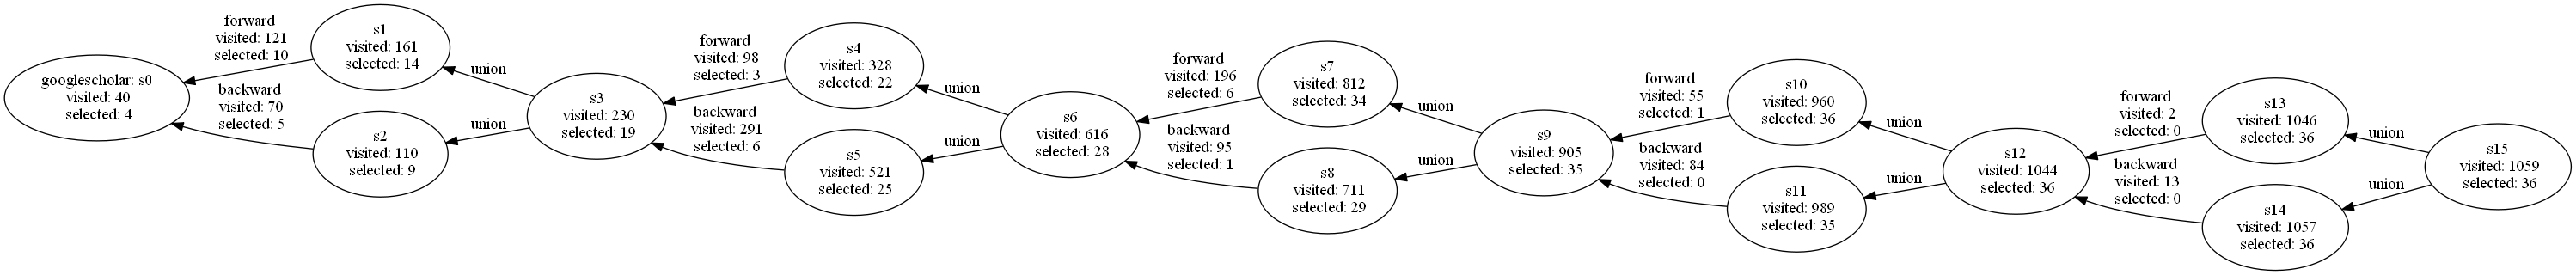

In [21]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "googlescholar: s0"
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin) \033[0m")

final.draw

In [22]:
#salvar(final, "E3final")

In [23]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df


d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scholar=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
print("\n \033[1mReport Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)\033[0m")

df1_style


 Report Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)


Scholar=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
googlescholar: s0,10,7.8,8.8,-,10,7.8,8.8,40,40,4,4
s2,7.1,9.8,8.3,backward,8.2,17.6,11.2,70,110,5,9
s1,8.3,19.6,11.6,forward,8.7,27.5,13.2,121,161,10,14
s3,nan,0,0,union,8.3,37.3,13.5,0,230,0,19
s5,2.1,11.8,3.5,backward,4.8,49,8.7,291,521,6,25
s4,3.1,5.9,4,forward,6.7,43.1,11.6,98,328,3,22
s6,nan,0,0,union,4.5,54.9,8.4,0,616,0,28
s8,1.1,2,1.4,backward,4.1,56.9,7.6,95,711,1,29
s7,3.1,11.8,4.9,forward,4.2,66.7,7.9,196,812,6,34
s9,nan,0,0,union,3.9,68.6,7.3,0,905,0,35


In [24]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 3 - Measures (Accumulated) \033[0m")
df3_style


 Report Strategy 3 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
3.4,70.6,6.5,1059,36


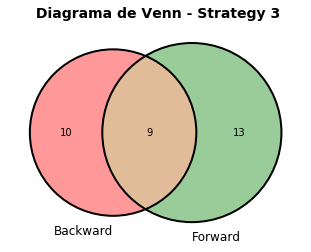

In [25]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 3',fontsize="14", fontweight="bold")
plt.show()

In [26]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['trienekens2009a', 'liu2005a', 'münch2013a', 'mccoy1998a', 'kowalczyk2010a', 'debou2000a', 'basili2007c', 'münch2013c', 'liu2006a', 'mcloughlin2010a', 'mandić2010d', 'becker2008b', 'basili2007a', 'trendowicz2011a', 'basili2007b', 'armbrust2010a', 'murugappan2003a', 'messnarz1999a', 'mandić2010a']
Forward ['mandić2010d', 'mcloughlin2010a', 'wang2005a', 'unterkalmsteiner2014a', 'trendowicz2011a', 'trienekens2004a', 'münch2013a', 'münch2013c', 'sun2010a', 'mcloughlin2010b', 'guzmán2010a', 'petersen2015a', 'becker2008b', 'mandić2010a', 'trendowicz2014a', 'becker2008a', 'armbrust2010b', 'kowalczyk2010a', 'armbrust2010a', 'birkhölzer2011a', 'cocozza2014a', 'trienekens2005a']



## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)


 Provenance Graph - Strategy 4 - Scopus + Snowballing (Guideline Wohlin) 


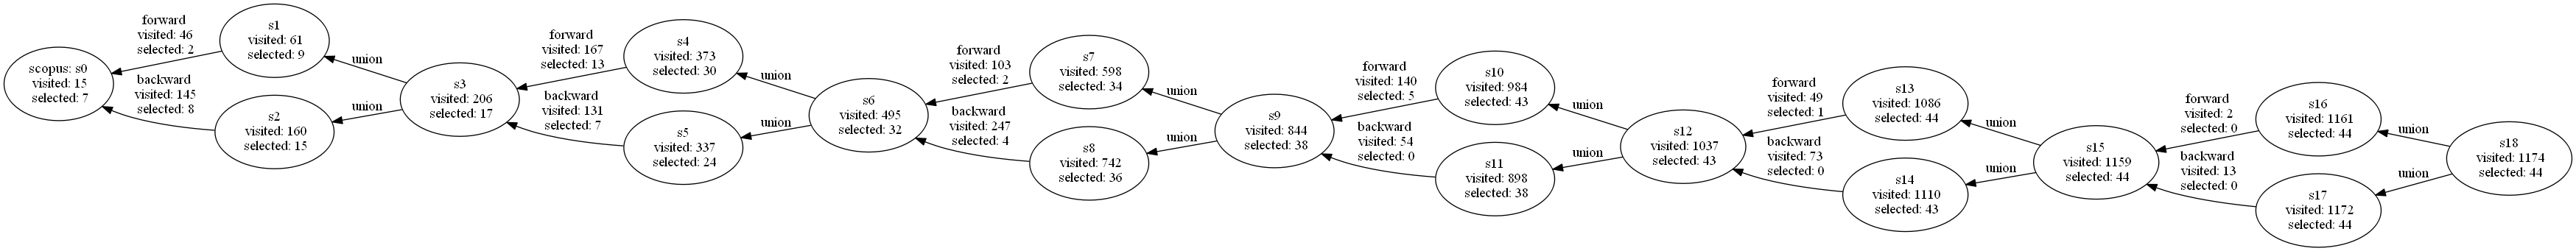

In [27]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

state = strategy.sfbu()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 4 - Scopus + Snowballing (Guideline Wohlin) \033[0m")

final.draw

In [28]:
#salvar(final, "E4final")

In [29]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
print("\n \033[1mReport Strategy 4 - Scopus + Snowballing (Guideline Wohlin)\033[0m")

df1_style


 Report Strategy 4 - Scopus + Snowballing (Guideline Wohlin)


Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
scopus: s0,46.7,13.7,21.2,-,46.7,13.7,21.2,15,15,7,7
s2,5.5,15.7,8.2,backward,9.4,29.4,14.2,145,160,8,15
s1,4.3,3.9,4.1,forward,14.8,17.6,16.1,46,61,2,9
s3,nan,0,0,union,8.3,33.3,13.2,0,206,0,17
s5,5.3,13.7,7.7,backward,7.1,47.1,12.4,131,337,7,24
s4,7.8,25.5,11.9,forward,8,58.8,14.2,167,373,13,30
s6,nan,0,0,union,6.5,62.7,11.7,0,495,0,32
s8,1.6,7.8,2.7,backward,4.9,70.6,9.1,247,742,4,36
s7,1.9,3.9,2.6,forward,5.7,66.7,10.5,103,598,2,34
s9,nan,0,0,union,4.5,74.5,8.5,0,844,0,38


In [30]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 4 - Measures (Accumulated) \033[0m")
df3_style


 Report Strategy 4 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
3.7,86.3,7.2,1174,44


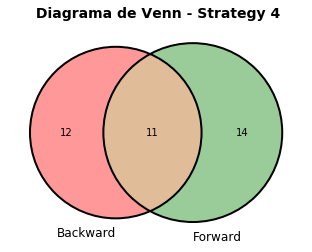

In [31]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 4',fontsize="14", fontweight="bold")
plt.show()

In [32]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['liu2005a', 'basili2007c', 'mcloughlin2010a', 'mandić2010d', 'basili2010a', 'trendowicz2011a', 'trienekens2009a', 'münch2013a', 'münch2013c', 'liu2006a', 'murugappan2003a', 'mandić2010b', 'becker2008b', 'basili2007a', 'basili2007b', 'mandić2010a', 'messnarz1999a', 'mccoy1998a', 'martins2007b', 'kowalczyk2010a', 'debou2000a', 'armbrust2010a', 'hinley1995a']
Forward ['mandić2010d', 'mcloughlin2010a', 'wang2005a', 'unterkalmsteiner2014a', 'trendowicz2011a', 'basili2010a', 'barreto2010a', 'trienekens2004a', 'münch2013a', 'münch2013c', 'sun2010a', 'mcloughlin2010b', 'martins2008a', 'mandić2010b', 'petersen2015a', 'becker2008b', 'mandić2010a', 'trendowicz2014a', 'armbrust2010b', 'kowalczyk2010a', 'stallinger2013a', 'armbrust2010a', 'birkhölzer2011a', 'cocozza2014a', 'trienekens2005a']


## Strategy 5 - Scopus + Snowballing (Short Paper)


 Provenance Graph - Strategy 5 - Scopus + Snowballing (Short Paper) 


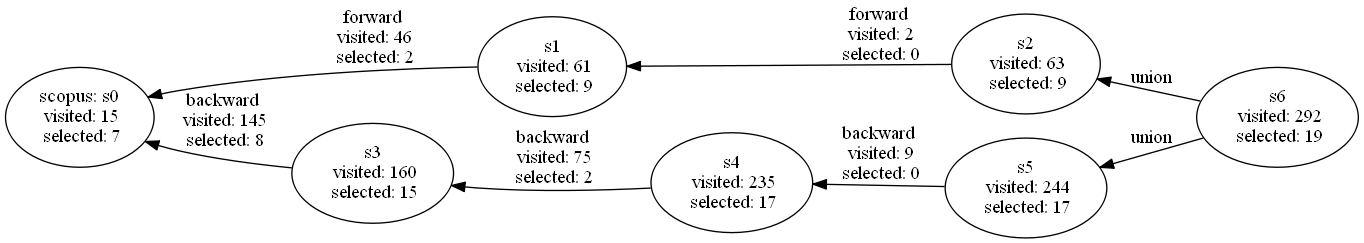

In [33]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 5 - Scopus + Snowballing (Short Paper) \033[0m")

final.draw

In [34]:
#salvar(final, "E5final")

In [35]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
print("\n \033[1mReport Strategy 5 - Scopus + Snowballing (Short Paper)\033[0m")

df1_style


 Report Strategy 5 - Scopus + Snowballing (Short Paper)


Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
s3,5.5,15.7,8.2,backward,9.4,29.4,14.2,145,160,8,15
scopus: s0,46.7,13.7,21.2,-,46.7,13.7,21.2,15,15,7,7
s4,2.7,3.9,3.2,backward,7.2,33.3,11.9,75,235,2,17
s1,4.3,3.9,4.1,forward,14.8,17.6,16.1,46,61,2,9
s5,0,0,0,backward,7,33.3,11.5,9,244,0,17
s2,0,0,0,forward,14.3,17.6,15.8,2,63,0,9
s6,nan,0,0,union,6.5,37.3,11.1,0,292,0,19


In [36]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 5 - Measures (Accumulated) \033[0m")
df3_style


 Report Strategy 5 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
6.5,37.3,11.1,292,19


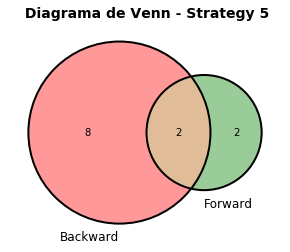

In [37]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 5',fontsize="14", fontweight="bold")
plt.show()

In [38]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['trienekens2009a', 'liu2005a', 'mccoy1998a', 'martins2007b', 'kowalczyk2010a', 'basili2007c', 'basili2007a', 'basili2010a', 'basili2007b', 'hinley1995a']
Forward ['petersen2015a', 'basili2010a', 'kowalczyk2010a', 'stallinger2013a']



  Bar Chart Strategy 5 


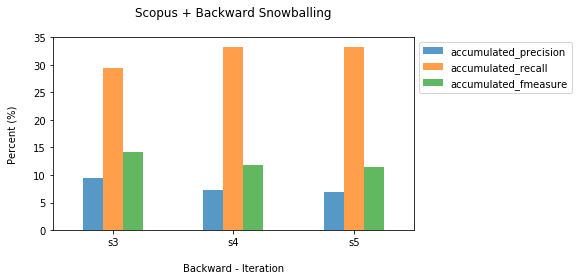

In [39]:
df1 = df.loc[df['operation'] == 'backward']

df1.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"], alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Backward Snowballing\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.45, 1.0))
ax.set_xticklabels(df1["state"])
plt.xlabel("\nBackward - Iteration")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()


  Bar Chart Strategy 5 


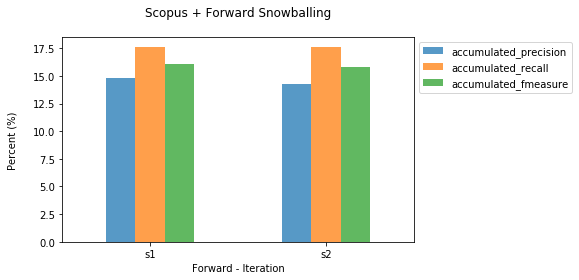

In [40]:
df2 = df.loc[df['operation'] == 'forward'].reset_index(drop=True)

df2.plot.bar(y=["accumulated_precision","accumulated_recall","accumulated_fmeasure"],alpha=0.75, rot=0)
ax = plt.gca()
ax.set_title("Scopus + Forward Snowballing\n")
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.0, 1.0))
ax.set_xticklabels(df2["state"])
plt.xlabel("Forward - Iteration")
plt.ylabel("Percent (%)\n")
print ('\n \033[1m Bar Chart Strategy 5 \033[0m')

plt.tight_layout()

## Strategy 6 - Scopus + Snowballing (JF BF)


 Provenance Graph - Strategy 6 - Scopus + Snowballing (JF BF) 


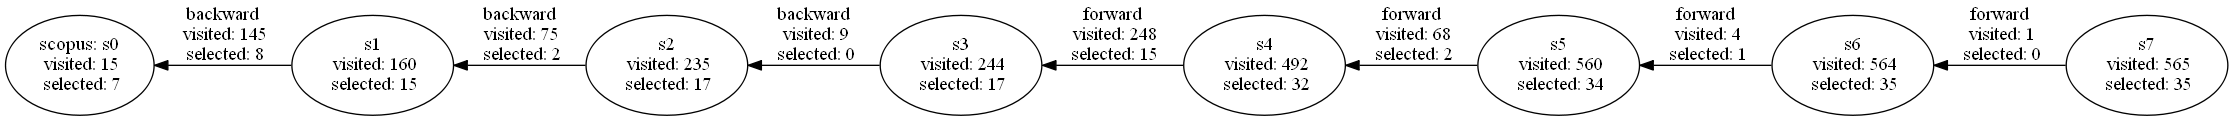

In [41]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
final = FinalSelection(state)
print("\n \033[1mProvenance Graph - Strategy 6 - Scopus + Snowballing (JF BF) \033[0m")
    
final.draw

In [42]:
#salvar(final, "E6final")

In [43]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
#print (strategy_row)
print("\n \033[1mReport Strategy 6 - Scopus + Snowballing (JF BF)\033[0m")

df1_style


 Report Strategy 6 - Scopus + Snowballing (JF BF)


Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
scopus: s0,46.7,13.7,21.2,-,46.7,13.7,21.2,15,15,7,7
s1,5.5,15.7,8.2,backward,9.4,29.4,14.2,145,160,8,15
s2,2.7,3.9,3.2,backward,7.2,33.3,11.9,75,235,2,17
s3,0,0,0,backward,7,33.3,11.5,9,244,0,17
s4,6,29.4,10,forward,6.5,62.7,11.8,248,492,15,32
s5,2.9,3.9,3.4,forward,6.1,66.7,11.1,68,560,2,34
s6,25,2,3.6,forward,6.2,68.6,11.4,4,564,1,35
s7,0,0,0,forward,6.2,68.6,11.4,1,565,0,35


In [44]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 6 - Measures (Accumulated) \033[0m")
df3_style


 Report Strategy 6 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
6.2,68.6,11.4,565,35


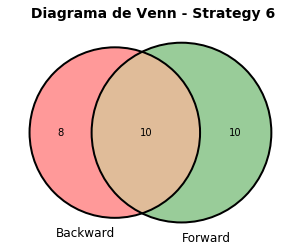

In [45]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 6',fontsize="14", fontweight="bold")
plt.show()

In [46]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['trienekens2009a', 'liu2005a', 'münch2013a', 'mccoy1998a', 'martins2007b', 'kowalczyk2010a', 'mandić2010b', 'basili2007c', 'münch2013c', 'mandić2010d', 'becker2008b', 'basili2007a', 'basili2010a', 'basili2007b', 'trendowicz2011a', 'armbrust2010a', 'mandić2010a', 'hinley1995a']
Forward ['mandić2010d', 'unterkalmsteiner2014a', 'trendowicz2011a', 'basili2010a', 'barreto2010a', 'münch2013a', 'münch2013c', 'sun2010a', 'martins2008a', 'mandić2010b', 'petersen2015a', 'becker2008b', 'mandić2010a', 'trendowicz2014a', 'armbrust2010b', 'kowalczyk2010a', 'stallinger2013a', 'armbrust2010a', 'birkhölzer2011a', 'cocozza2014a']


## Strategy 7 - Scopus + Snowballing (JF FB)


 Provenance Graph - Strategy 7 - Scopus + Snowballing (JF FB) 


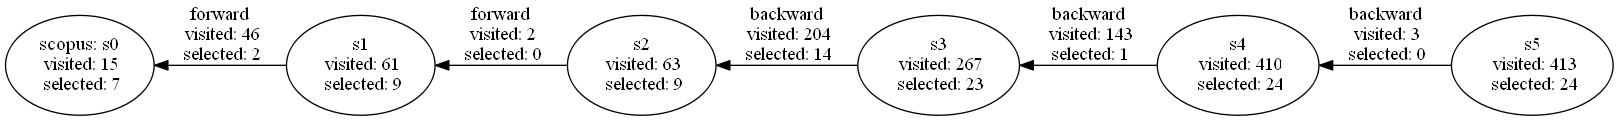

In [47]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()

if strategy.initial.name == "s0":
    strategy.initial.name = "scopus: s0"
final = FinalSelection(state)    
print("\n \033[1mProvenance Graph - Strategy 7 - Scopus + Snowballing (JF FB) \033[0m")

final.draw

In [48]:
#salvar(final, "E7final")

In [49]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3 
for coluna in ['precision', 'recall', 'fmeasure', 'accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure']:
    df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df[coluna] = df[coluna].map('{:,.2f}'.format)
      
df1 = df[["state","precision", "recall", "fmeasure", "operation", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "delta_visited", "visited", "delta_related","related"]]
df1.columns = ['Scopus=s0 /State', 'Precision%', 'Recall%', 'FMeasure%','Operation','Accumulated Precision%', 'Accumulated Recall%', 'Accumulated F_Measure%','Delta Visited','Visited','Delta Related','Related' ]
    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
print("\n \033[1mReport Strategy 7 - Scopus + Snowballing (JF FB)\033[0m")
#print (strategy_row)
df1_style


 Report Strategy 7 - Scopus + Snowballing (JF FB)


Scopus=s0 /State,Precision%,Recall%,FMeasure%,Operation,Accumulated Precision%,Accumulated Recall%,Accumulated F_Measure%,Delta Visited,Visited,Delta Related,Related
scopus: s0,46.7,13.7,21.2,-,46.7,13.7,21.2,15,15,7,7
s1,4.3,3.9,4.1,forward,14.8,17.6,16.1,46,61,2,9
s2,0,0,0,forward,14.3,17.6,15.8,2,63,0,9
s3,6.9,27.5,11,backward,8.6,45.1,14.5,204,267,14,23
s4,0.7,2,1,backward,5.9,47.1,10.4,143,410,1,24
s5,0,0,0,backward,5.8,47.1,10.3,3,413,0,24


In [50]:
df2 = df[["accumulated_precision", "accumulated_recall", "accumulated_fmeasure","visited", "related"]]
df2.columns = ['Precision %', 'Recall %', 'F-Measure %', 'Visited', 'Selected']

indexdf = df.index[-1]
df3 = df2.loc[df.index == indexdf]

df3_style = df3.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df3_style.hidden_index = True
print("\n \033[1mReport Strategy 7 - Measures (Accumulated) \033[0m")
df3_style


 Report Strategy 7 - Measures (Accumulated) 


Precision %,Recall %,F-Measure %,Visited,Selected
5.8,47.1,10.3,413,24


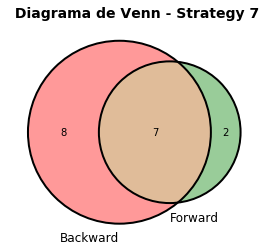

In [51]:
strategy.initial.name = "s0"
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title(' Diagrama de Venn - Strategy 7',fontsize="14", fontweight="bold")
plt.show()

In [52]:
#Backward - Execução de backward em sets[0]
print("\n\033[1mReport Diagrama de Venn \033[0m\n")
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)


Report Diagrama de Venn 

Backward ['trienekens2009a', 'liu2005a', 'münch2013a', 'mccoy1998a', 'martins2007b', 'kowalczyk2010a', 'mandić2010b', 'basili2007c', 'münch2013c', 'mandić2010d', 'basili2007a', 'basili2010a', 'basili2007b', 'trendowicz2011a', 'hinley1995a']
Forward ['münch2013a', 'kowalczyk2010a', 'mandić2010b', 'stallinger2013a', 'münch2013c', 'mandić2010d', 'petersen2015a', 'trendowicz2011a', 'basili2010a']


# Analyses

In [53]:
%matplotlib inline
import pandas as pd

In [54]:
df = pd.DataFrame (array)
#Esse array possui elementos do (11 ate o 23) 11o elem. até o último elem. pq estamos incluindo desde a Estrategia 1 somente esses elementos em strategy_row = [name] + last[11:].
#df.columns = ['name',"related","visited", "final_selected", "accumulated_precision", "accumulated_recall", "accumulated_fmeasure", "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
#df.index = df['Estratégia']
#df

df1 = df[[0, 4, 5, 6, 2, 1, 3]].copy()  #seleção de somente alguns elementos do df do array, com posições diferentes 
df1.columns = ['Strategy','Precision %', 'Recall %', 'F-Measure %','Visited', 'Related', 'Final Selected']

d_decimals = 3    
for coluna in ['Precision %', 'Recall %', 'F-Measure %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)
    #df1[coluna] = df1[coluna].map('{:,.2f}'.format)

    
df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
dfEAll=df1
df1_style.hidden_index = True
df1_style

Strategy,Precision %,Recall %,F-Measure %,Visited,Related,Final Selected
E1,4.4,43.1,8,497,22,15
E2,2.7,100,5.3,1873,51,30
E3,3.4,70.6,6.5,1059,36,22
E4,3.7,86.3,7.2,1174,44,25
E5,6.5,37.3,11.1,292,19,14
E6,6.2,68.6,11.4,565,35,20
E7,5.8,47.1,10.3,413,24,15



  Bar Chart Strategies 


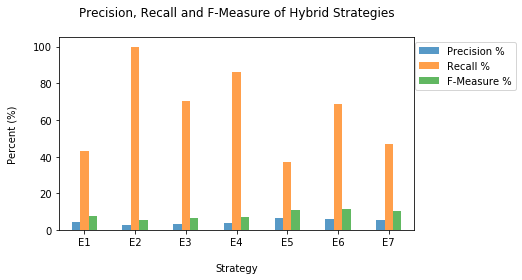

In [55]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df1.loc[:, df1.columns.difference(exclude)].plot.bar(y=['Precision %', 'Recall %', 'F-Measure %'],alpha=0.75, rot=0 )
ax.set_title("Precision, Recall and F-Measure of Hybrid Strategies\n")
ax.set_xticklabels(df1['Strategy'])
ax.legend(loc = 'best')
ax.get_legend().set_bbox_to_anchor((1.3, 1.0))
plt.xlabel("\nStrategy")
plt.ylabel("Percent (%)\n")
plt.tight_layout()
print ('\n \033[1m Bar Chart Strategies \033[0m')

In [56]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [57]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})

In [58]:
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title

# Research Questions

In [59]:
print ("\nRQ1) Which of the digital libraries used in the published SLR is more efficient?")

#RQ1.1) Qual busca em biblioteca digital encontra mais artigos incluídos na lista de selecionados da SLR 
#publicada dentre o resultado retornado na busca (Precision)?
#RQ1.2) Qual busca em biblioteca digital recupera todos os artigos que estavam incluídos na lista de 
#selecionados da SRL publicada (Recall)?
#RQ1.3) Qual biblioteca digital apresenta melhor média harmônica (F-Measure)?

dfE1


RQ1) Which of the digital libraries used in the published SLR is more efficient?


Digital Library,Precision %,Recall %,F-Measure %
sciencedirect,0.5,2,0.8
webofscience,50,9.8,16.4
elcompendex,38.5,9.8,15.6
springer,1.4,3.9,2.1
acm,5,9.8,6.6
ieee,14,11.8,12.8
scopus,46.7,13.7,21.2


In [60]:
print ("\nRQ2) Which of the hybrid strategies is more efficient?")

#RQ2.1)A estratégia híbrida envolve analisar menos artigos quando comparada 
#com as SLRs publicadas que conduziram buscas somente em bases de dados? Precision.
#RQ2.2)A estratégia híbrida recupera todos os artigos que estavam incluídos 
#na SLR publicada que conduziu as buscas em bases de dados? Recall.
#RQ2.3)Qual estratégia híbrida apresenta melhor média harmônica? F-measure.
dfEAll

df1 = dfEAll.drop(dfEAll.index[[0]])

exclude = ['Visited', 'Related', 'Final Selected']
df1 = df1.loc[:, dfEAll.columns.difference(exclude)]

df2 = df1[['Strategy','Precision %', 'Recall %', 'F-Measure %']]      
df2.columns = ['Strategy','Precision %', 'Recall %', 'F-Measure %']
df1_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
df1_style


RQ2) Which of the hybrid strategies is more efficient?


Strategy,Precision %,Recall %,F-Measure %
E2,2.7,100,5.3
E3,3.4,70.6,6.5
E4,3.7,86.3,7.2
E5,6.5,37.3,11.1
E6,6.2,68.6,11.4
E7,5.8,47.1,10.3


In [61]:
print ("\nRQ3) Which of the strategies is more efficient?")

#RQ3.1)A estratégia envolve analisar menos artigos quando comparada 
#com as SLRs publicadas que conduziram buscas somente em bases de dados? Precision.
#RQ3.2)A estratégia recupera todos os artigos que estavam incluídos 
#na SLR publicada que conduziu as buscas em bases de dados? Recall.
#RQ3.3) Qual estratégia apresenta melhor média harmônica? F-measure.

dfEAll
exclude = ['Visited', 'Related', 'Final Selected']
df1 = dfEAll.loc[:, dfEAll.columns.difference(exclude)]
df2 = df1[['Strategy','Precision %', 'Recall %', 'F-Measure %']]      
df2.columns = ['Strategy','Precision %', 'Recall %', 'F-Measure %']
df1_style = df2.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
df1_style


RQ3) Which of the strategies is more efficient?


Strategy,Precision %,Recall %,F-Measure %
E1,4.4,43.1,8
E2,2.7,100,5.3
E3,3.4,70.6,6.5
E4,3.7,86.3,7.2
E5,6.5,37.3,11.1
E6,6.2,68.6,11.4
E7,5.8,47.1,10.3


In [62]:
print ("\nRQ4) How many selected articles does the digital library find through the direct search for the title of the article?")
df = pd.DataFrame (arraysearch)
df1 = df[[0, 1]] 
df1.columns = ['Digital Library','Recall %']

d_decimals = 3    
for coluna in ['Recall %']:
    df1[coluna] = df1[coluna].apply(lambda x: round(x,d_decimals)*100)

df1_style = df1.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df1_style.hidden_index = True
df1_style



RQ4) How many selected articles does the digital library find through the direct search for the title of the article?


Digital Library,Recall %
scopus,82.4
springer,31.4
ieee,27.5
sciencedirect,3.9
acm,11.8
webofscience,52.9
elcompendex,68.6
